In [ ]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

In [ ]:
LearningRate = 1e-4
EPOCHS = 10 #number of complete passes through the training dataset
Batch_size = 512 #number of samples processed before the model is updated

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DIR='/content/drive/MyDrive/maskimages'
CATEGORIES=['with_mask','without_mask']

data =[]
labels = []

In [ ]:
from skimage.exposure import equalize_adapthist
from skimage.transform import resize
        
for category in CATEGORIES:
    path=os.path.join(DIR,category)
    for img in os.listdir(path):
        image=os.path.join(path,img)
        image =tf.keras.preprocessing.image.load_img(image,target_size=(96,96))
        image = tf.keras.preprocessing.image.img_to_array(image)
        image=tf.keras.applications.mobilenet_v2.preprocess_input(image)
        data.append(image)
        labels.append(category)        
    

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [ ]:
def display_20_image(images):
    
    w = 10
    h = 10
    fig = plt.figure(figsize=(9, 13))
    columns = 4
    rows = 5
    # prep (x,y) for extra plotting
    xs = np.linspace(0, 2*np.pi, 60)  # from 0 to 2pi
    ys = np.abs(np.sin(xs))           # absolute of sine
    ax = []

    for i in range(columns*rows):
        img = np.random.randint(10, size=(h,w))
        ax.append( fig.add_subplot(rows, columns, i+1) )
        plt.imshow(images[i].reshape(96,96,3))

    # do extra plots on selected axes/subplots
    # note: index starts with 0
    ax[2].plot(xs, 3*ys)
    ax[19].plot(ys**2, xs)

    plt.show()  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

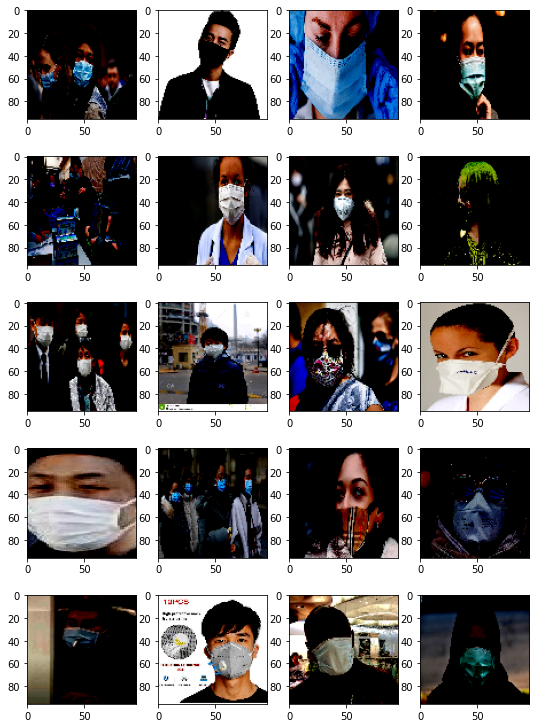

In [ ]:
display_20_image(data)

In [ ]:
encoder = LabelBinarizer()
labels=encoder.fit_transform(labels)

In [ ]:
data=np.array(data,dtype='float32')
labels=np.array(labels)

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(data,labels,test_size=0.2,random_state=42,stratify=labels)
data=[]

In [ ]:
aug =tf.keras.preprocessing.image.ImageDataGenerator(
rotation_range=20,
zoom_range=0.15,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.15,
horizontal_flip=True,
fill_mode="nearest")

In [ ]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = tf.keras.applications.MobileNetV2(weights="imagenet", include_top=False,
input_tensor=Input(shape=(96, 96, 3)))

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(3, 3))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [ ]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False
    

In [ ]:
print("[INFO] compiling model...")
opt = Adam(lr=LearningRate, decay=LearningRate / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
metrics=["accuracy"])

model.summary()

[INFO] compiling model...
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 48, 48, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 48, 48, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 48, 48, 32)   0           ['bn_Conv1[0][0]']               
                                                                    

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 block_6_depthwise_BN (BatchNor  (None, 6, 6, 192)   768         ['block_6_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_6_depthwise_relu (ReLU)  (None, 6, 6, 192)    0           ['block_6_depthwise_BN[0][0]']   
                                                                                                  
 block_6_project (Conv2D)       (None, 6, 6, 64)     12288       ['block_6_depthwise_relu[0][0]'] 
                                                                                                  
 block_6_project_BN (BatchNorma  (None, 6, 6, 64)    256         ['block_6_project[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_7_e

In [ ]:
print("[INFO] training head...")
H = model.fit(
X_train,y_train,
validation_freq=0.2,
epochs=EPOCHS)

[INFO] training head...
Epoch 1/10
189/189 [==============================] - 31s 150ms/step - loss: 0.3285 - accuracy: 0.8730
Epoch 2/10
189/189 [==============================] - 29s 155ms/step - loss: 0.1253 - accuracy: 0.9501
Epoch 3/10
189/189 [==============================] - 28s 151ms/step - loss: 0.0964 - accuracy: 0.9648
Epoch 4/10
189/189 [==============================] - 29s 152ms/step - loss: 0.0761 - accuracy: 0.9729
Epoch 5/10
189/189 [==============================] - 29s 152ms/step - loss: 0.0617 - accuracy: 0.9775
Epoch 6/10
189/189 [==============================] - 29s 154ms/step - loss: 0.0546 - accuracy: 0.9802
Epoch 7/10
189/189 [==============================] - 29s 151ms/step - loss: 0.0501 - accuracy: 0.9813
Epoch 8/10
189/189 [==============================] - 28s 151ms/step - loss: 0.0461 - accuracy: 0.9848
Epoch 9/10
189/189 [==============================] - 29s 151ms/step - loss: 0.0370 - accuracy: 0.9871
Epoch 10/10
189/189 [============================

In [ ]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(X_test, batch_size=Batch_size)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = predIdxs>0.5

# show a nicely formatted classification report
print(classification_report(y_test, predIdxs,
target_names=encoder.classes_))

# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.hdf5", save_format="hdf5")

[INFO] evaluating network...
              precision    recall  f1-score   support

   with_mask       0.97      0.98      0.98       745
without_mask       0.98      0.98      0.98       768

    accuracy                           0.98      1513
   macro avg       0.98      0.98      0.98      1513
weighted avg       0.98      0.98      0.98      1513

[INFO] saving mask detector model...
